In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv("Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv")


df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')
df = df.dropna()

print("Data Overview:\n")
print(df.info())
display(df.head())
print(df.describe())


Data Overview:

<class 'pandas.core.frame.DataFrame'>
Index: 1898 entries, 1184 to 1800
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1898 non-null   datetime64[ns]
 1   Local Route   1898 non-null   int64         
 2   Light Rail    1898 non-null   int64         
 3   Peak Service  1898 non-null   int64         
 4   Rapid Route   1898 non-null   int64         
 5   School        1898 non-null   int64         
 6   Other         1898 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 118.6 KB
None


,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
1184,2019-07-08,13078,9442,422,18848,0,0.0
622,2019-07-09,13835,10550,455,19862,0,1.0
1195,2019-07-10,13856,10066,421,19502,0,1.0
1674,2019-07-11,12776,9536,421,19204,0,0.0
1376,2019-07-12,12614,9413,344,18057,0,1.0


                                Date   Local Route    Light Rail  \
count                           1898   1898.000000   1898.000000   
mean   2022-02-16 03:16:30.094836736   9921.582719   7216.707587   
min              2019-07-08 00:00:00     21.000000    375.000000   
25%              2020-10-30 06:00:00   3054.250000   4481.000000   
50%              2022-02-16 12:00:00  11432.500000   7536.000000   
75%              2023-06-05 18:00:00  15509.000000  10008.250000   
max              2024-09-23 00:00:00  21070.000000  15154.000000   
std                              NaN   6099.992129   3324.006188   

       Peak Service   Rapid Route       School        Other  
count   1898.000000   1898.000000  1898.000000  1898.000000  
mean     179.925711  12630.298736  2364.301370    43.390411  
min        0.000000     49.000000     0.000000     0.000000  
25%        0.000000   6396.000000     0.000000    14.000000  
50%      194.000000  13160.000000   687.000000    40.000000  
75%      313.00

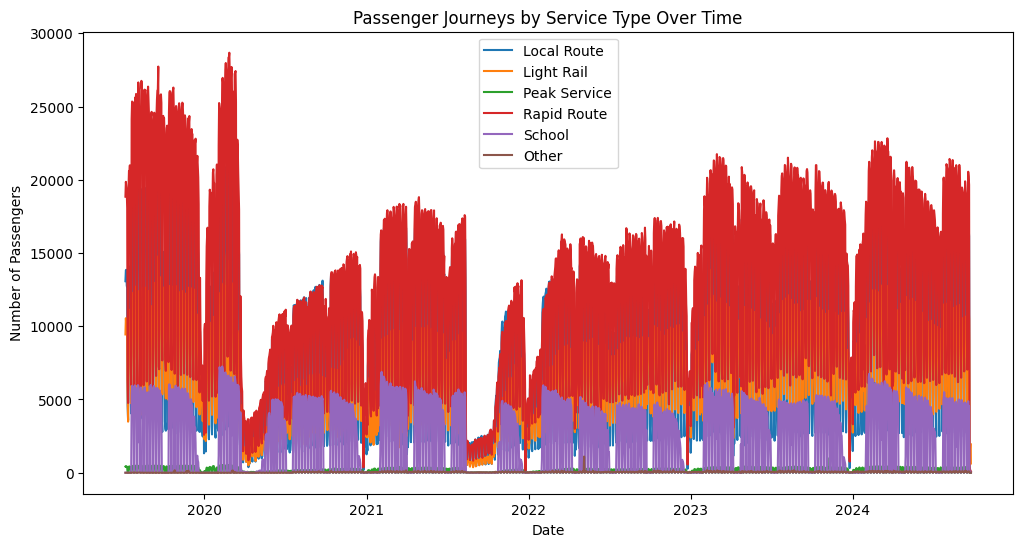

In [54]:
plt.figure(figsize=(12,6))
for col in df.columns[1:]:
    plt.plot(df['Date'], df[col], label=col)
plt.title("Passenger Journeys by Service Type Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()


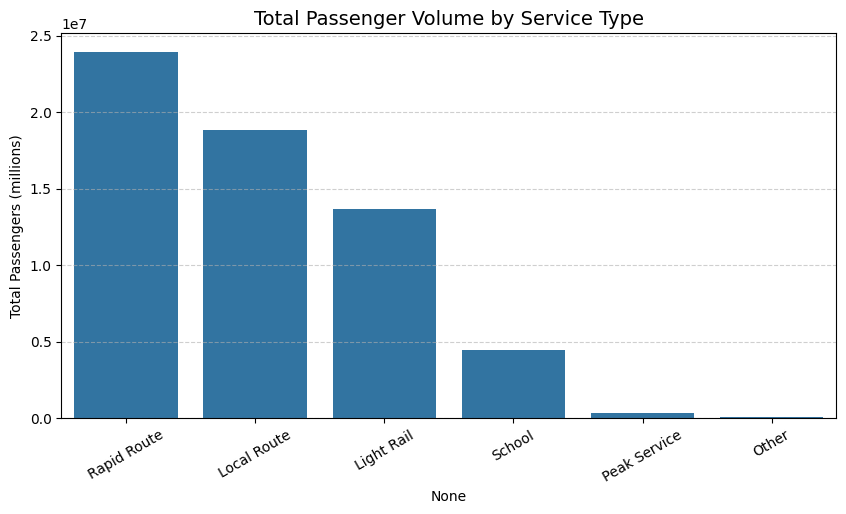


--- Key Insights ---
1. The service type with the highest average passengers is 'Rapid Route' with an average of 12630 passengers per day.
2. 'Rapid Route' shows the highest volatility, indicating irregular passenger patterns.
3. 'School' shows the highest overall growth since the start of the dataset (inf%).
4. The highest correlation exists between 'Light Rail' and 'Rapid Route' (0.97).


In [57]:
# Insights Section
insights = []


service_totals = df.drop(columns=["Date"]).sum().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=service_totals.index, y=service_totals.values)
plt.title("Total Passenger Volume by Service Type", fontsize=14)
plt.ylabel("Total Passengers (millions)")
plt.xticks(rotation=30)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

avg_passengers = df.mean(numeric_only=True)
top_service = avg_passengers.idxmax()
insights.append(f"1. The service type with the highest average passengers is '{top_service}' with an average of {avg_passengers[top_service]:.0f} passengers per day.")


volatility = df.std(numeric_only=True)
volatile_service = volatility.idxmax()
insights.append(f"2. '{volatile_service}' shows the highest volatility, indicating irregular passenger patterns.")


growth = ((df.iloc[-1,1:] - df.iloc[0,1:]) / df.iloc[0,1:]) * 100
fastest_growth = growth.idxmax()
insights.append(f"3. '{fastest_growth}' shows the highest overall growth since the start of the dataset ({growth[fastest_growth]:.2f}%).")


corr = df.corr(numeric_only=True)
top_corr = corr.unstack().sort_values(ascending=False)
top_corr = top_corr[top_corr < 1].head(1)
pair = top_corr.index[0]
insights.append(f"4. The highest correlation exists between '{pair[0]}' and '{pair[1]}' ({top_corr.values[0]:.2f}).")

print("\n--- Key Insights ---")
for i in insights:
    print(i)


Forecast for Local Route:
1898    10930.298832
1899    16243.395822
1900    13399.764049
1901     6130.847682
1902      519.360503
Name: predicted_mean, dtype: float64


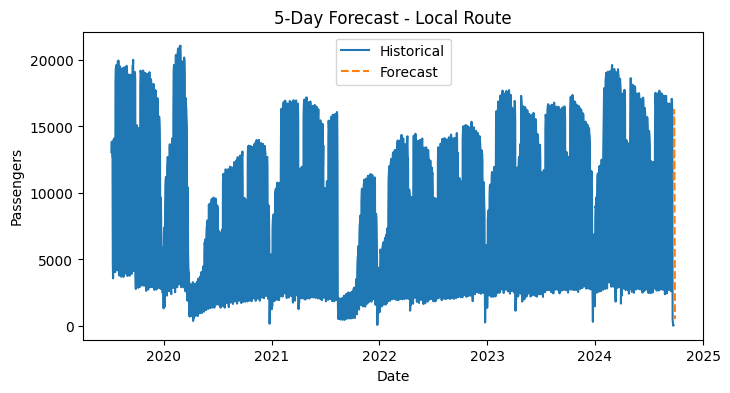


Forecast for Light Rail:
1898     7911.642397
1899    10331.465213
1900     8262.604119
1901     4104.105856
1902     1204.686611
Name: predicted_mean, dtype: float64


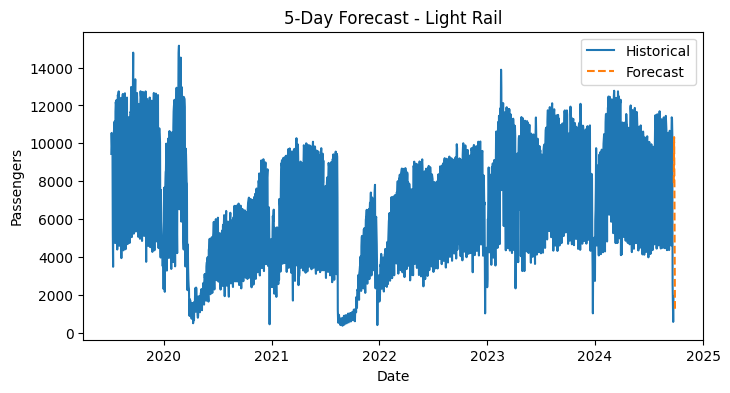


Forecast for Peak Service:
1898    212.356751
1899    336.006961
1900    300.215169
1901    160.394694
1902     35.096458
Name: predicted_mean, dtype: float64


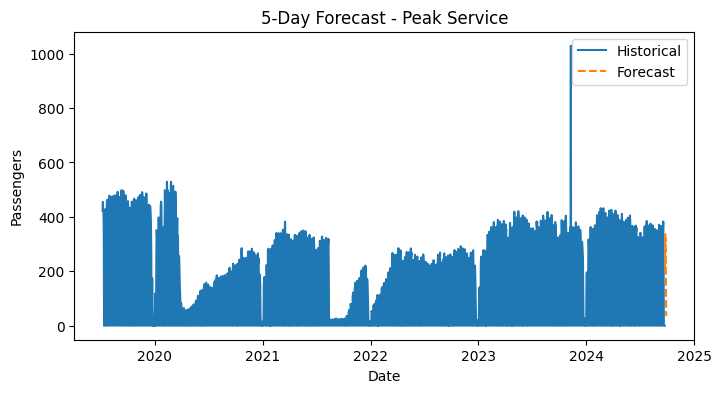

In [38]:
# --- Forecasting for Next 5 Days ---
forecast_results = {}
future_days = 5

for col in df.columns[1:4]:
    series = df[col].astype(float)
    model = ARIMA(series, order=(2,1,2))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=future_days)
    forecast_results[col] = forecast

    print(f"\nForecast for {col}:")
    print(forecast)

    # Plot forecast
    plt.figure(figsize=(8,4))
    plt.plot(df['Date'], series, label='Historical')
    plt.plot(pd.date_range(df['Date'].iloc[-1], periods=future_days+1, freq='D')[1:], forecast,
             label='Forecast', linestyle='--')
    plt.title(f"5-Day Forecast - {col}")
    plt.xlabel("Date")
    plt.ylabel("Passengers")
    plt.legend()
    plt.show()


In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


evaluation_results = {}


def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, mse, rmse, mape


for col in df.columns[1:4]:
    series = df[col].astype(float)


    train, test = series[:-future_days], series[-future_days:]


    model = ARIMA(train, order=(2,1,2))
    model_fit = model.fit()


    forecast = model_fit.forecast(steps=future_days)


    mae, mse, rmse, mape = evaluate_forecast(test.values, forecast.values)
    evaluation_results[col] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape
    }

    print(f"\nEvaluation Metrics for {col}:")
    print(f"MAE:  {mae:.2f}")
    print(f"MSE:  {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")


eval_df = pd.DataFrame(evaluation_results).T
print("\n=== Evaluation Summary ===")
print(eval_df)



Evaluation Metrics for Local Route:
MAE:  6179.45
MSE:  54153214.54
RMSE: 7358.89
MAPE: 12194.48%

Evaluation Metrics for Light Rail:
MAE:  4020.90
MSE:  23575773.86
RMSE: 4855.49
MAPE: 350.08%

Evaluation Metrics for Peak Service:
MAE:  103.70
MSE:  15399.84
RMSE: 124.10
MAPE: inf%

=== Evaluation Summary ===
                      MAE           MSE         RMSE          MAPE
Local Route   6179.445025  5.415321e+07  7358.886773  1.219448e+04
Light Rail    4020.896932  2.357577e+07  4855.489045  3.500822e+02
Peak Service   103.698866  1.539984e+04   124.096079           inf


In [39]:
forecast_df = pd.DataFrame(forecast_results)
forecast_df.index = pd.date_range(df['Date'].iloc[-1], periods=future_days+1, freq='D')[1:]
forecast_df.index.name = "Forecast_Date"
print("\nFinal 5-Day Forecast Table:")
display(forecast_df)



Final 5-Day Forecast Table:


,Local Route,Light Rail,Peak Service
Forecast_Date,,,
2024-09-24,10930.298832,7911.642397,212.356751
2024-09-25,16243.395822,10331.465213,336.006961
2024-09-26,13399.764049,8262.604119,300.215169
2024-09-27,6130.847682,4104.105856,160.394694
2024-09-28,519.360503,1204.686611,35.096458
